### **Содержательная постановка задачи**

**Задача:**
Из множества треков Х = {х1, x2, ... , хm), каждый из которых характеризуется набором аудио-признаков D = {d1, d2, ..., dn}, таких как энергия, танцевальность, темп, громкость и так далее, разработать систему кластеризации музыкальных треков C = {c1, c2, ..., cp} на основе их аудио-характеристик для автоматического группирования треков по схожим музыкальным свойствам Sik

**Дано:**
Х - пространство объектов: музыкальные треки
Х^l - обучающая выборка: данные о музыкальных треках из датасета
p: X*X -> [0; ∞] - функция расстояния между объектами: евклидово расстояние

**Найти:** 
C - множество кластеров 
а: X -> C - алгоритм кластеризации: сгущение в сферах и их стабилизация (каждый кластер состоит из близких объектов, треки в одном кластере имеют похожие признаки;  объекты разных кластеров существенно различны, например треки могут быть поделены на весеые, грустные, спокойные или динамичные)

**Цель:**
Определить признаки которые наиболее сильно отражают характерность трека, разделить музыкальные треки на заранее заданное количество кластеров на основе их аудио-характеристик, чтобы выявить группы треков с похожими музыкальными свойствами. Результаты кластеризации можно использовать для составления рекомендаций пользователям или для составления плейлистов по темам в приложениях для прослушивания музыки (например Яндекс музыка)

**Объект исследования:**
Музыкальные треки, представленные в датасете (https://www.kaggle.com/datasets/solomonameh/spotify-music-dataset)

**Постановка задачи**

Пусть Х = {х1, x2, ... , хm) - множество музыкальных треков, где м - количество треков. Каждый трек Х характеризуется вектором аудио-признаков D = {d1^k, d2^k, ..., dn^k}, где каждый признак приведен к нормализованному значению, а n - количество признаков. 
Метрика растояния рассчитывается как евклидово расстояние:

p: X*X -> [0; ∞]

p(xn^k,xn^l) = |d^k - d^l|

Требуется построить разбиение множества X на непересекающиеся кластеры C = {c1, c2, ..., cp, где выполняются условия:
 1) полнота покрытия (каждый элемент принадлежит хотя бы одному кластеру, в случае если точка не будет распределена ни в один из выделенных кластеров, она попадет в "не распределенный кластер" (метка -1)), если после кластеризации более 20% треков имею метку -1 - "не распределенный кластер", то условие не выполняется; 
2) неприкостновенности (ни один трек не может одновременно принадлежать двум разным кластерам, все классы строго разграничены), точка xm добавляется только в один кластер при первом попадании в сферу
3) для каждого кластера Ci существует сфера - с радиусом Ri и центром μi такая, что все точки принадлежат своей сфере (условие 2), а центры стабилизируются по алгоритму сгущения (при выбранном методе: сгущения в сферах и их стабилизация)



### **Импорт библиотек, загрузка и обработка данных**

In [119]:
# Импортирую библиотеки pandas для работы с табличными данными и из библиотеки scikit-learn импортируется класс StandardScaler для стандартизации данных (преобразование данных таким образом, чтобы их среднее значение было равно 0, а стандартное отклонение — 1)
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Импортирую библиотеку seaborn и matplotlib.pyplot для создания матрицы кореляции и графиков
import seaborn as sns
import matplotlib.pyplot as plt
# Импортирую класс PCA для выбора оптимальных признаков 
from sklearn.decomposition import PCA
# Импортирую функцию pairwise_distances из библиотеки scikit-learn, которая вычисляет расстояния между объектами
from sklearn.metrics import pairwise_distances
# Импортирую класс NearestNeighbors из библиотеки scikit-learn, который используется для поиска ближайших соседей
from sklearn.neighbors import NearestNeighbors
# Импортирую класс KMeans для проверки количества кластеров с помощью метода "локтя"
from sklearn.cluster import KMeans
# Импортирую класс KneeLocator из библиотеки kneed для автоматического поиска "локтя"
from kneed import KneeLocator
# Импортирую библиотеку NumPy для работы с массивами и математическими операциями
import numpy as np
# Импортирую класс TSNE из библиотеки scikit-learn для снижения размерности данных
from sklearn.manifold import TSNE

Загрузка данных из csv-файла:

In [ ]:
# Задаю путь к файлу high_popularity_spotify_data.csv и с помощью функции read_csv загружаю данные из csv-файла в переменную df
path = 'C:\\Users\\marga\\OneDrive - НИТУ МИСиС\\Рабочий стол\\ДЗ1_спецглавы\\high_popularity_spotify_data.csv'
# С 
pd.set_option('display.max_columns', None)
df = pd.read_csv(path)
# Вывожу первые 5 строк таблицы df с помощью метода head() для просмотра как выглядят данные
df.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,track_popularity,track_href,uri,track_album_name,playlist_name,analysis_url,track_id,track_name,track_album_release_date,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,100,https://api.spotify.com/v1/tracks/2plbrEY59Iik...,spotify:track:2plbrEY59IikOBgBGLjaoe,Die With A Smile,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/2plb...,2plbrEY59IikOBgBGLjaoe,Die With A Smile,2024-08-16,0.0000,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,97,https://api.spotify.com/v1/tracks/6dOtVTDdiauQ...,spotify:track:6dOtVTDdiauQNBQEDOtlAB,HIT ME HARD AND SOFT,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/6dOt...,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,2024-05-17,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4,0.0368,93,https://api.spotify.com/v1/tracks/7ne4VBA60CxG...,spotify:track:7ne4VBA60CxGM75vw0EYad,The Secret of Us (Deluxe),Today's Top Hits,https://api.spotify.com/v1/audio-analysis/7ne4...,7ne4VBA60CxGM75vw0EYad,That’s So True,2024-10-18,0.0000,0hBRqPYPXhr1RkTDG3n4Mk,1,1,166300,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4,0.0634,81,https://api.spotify.com/v1/tracks/1d7Ptw3qYcfp...,spotify:track:1d7Ptw3qYcfpdLNL5REhtJ,Short n' Sweet,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/1d7P...,1d7Ptw3qYcfpdLNL5REhtJ,Taste,2024-08-23,0.0000,4B4Elma4nNDUyl6D5PvQkj,0,0,157280,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4,0.2600,98,https://api.spotify.com/v1/tracks/5vNRhkKd0yEA...,spotify:track:5vNRhkKd0yEAg8suGBpjeY,APT.,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/5vNR...,5vNRhkKd0yEAg8suGBpjeY,APT.,2024-10-18,0.0000,2IYQwwgxgOIn7t3iF6ufFD,0,0,169917,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


Отображение типа данных признаков:

In [121]:
# Вывожу типы всех признаков датафрейма
i = 1
for col, dtype in df.dtypes.items():
    print(f"{i} {col}: {dtype}")
    i += 1

1 energy: float64
2 tempo: float64
3 danceability: float64
4 playlist_genre: object
5 loudness: float64
6 liveness: float64
7 valence: float64
8 track_artist: object
9 time_signature: int64
10 speechiness: float64
11 track_popularity: int64
12 track_href: object
13 uri: object
14 track_album_name: object
15 playlist_name: object
16 analysis_url: object
17 track_id: object
18 track_name: object
19 track_album_release_date: object
20 instrumentalness: float64
21 track_album_id: object
22 mode: int64
23 key: int64
24 duration_ms: int64
25 acousticness: float64
26 id: object
27 playlist_subgenre: object
28 type: object
29 playlist_id: object


Отбор количественных признаков для кластеризации:

In [122]:
# В переменную drop_columns сохраняю наименования столбцов, которые являются качественными, для идентификации трека в дальнейшем оставляю признаки track_id, track_artist и track_name
drop_columns = ['playlist_genre', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']
# В переменную audio_features сохраняю наименование столбцов
audio_features = ['energy', 'tempo', 'danceability', 'loudness', 'liveness', 'valence', 'time_signature', 'speechiness', 'track_popularity', 'instrumentalness', 'mode', 'key', 'duration_ms', 'acousticness']
# Удаляю качественные признаки
df_cluster = df.drop(columns=drop_columns)

Проверка пропущенных значений:

In [123]:
# Вывожу общую информацию о данных (типы столбцов, количество пропущенных значений)
print(df_cluster.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   energy            1686 non-null   float64
 1   tempo             1686 non-null   float64
 2   danceability      1686 non-null   float64
 3   loudness          1686 non-null   float64
 4   liveness          1686 non-null   float64
 5   valence           1686 non-null   float64
 6   track_artist      1686 non-null   object 
 7   time_signature    1686 non-null   int64  
 8   speechiness       1686 non-null   float64
 9   track_popularity  1686 non-null   int64  
 10  track_id          1686 non-null   object 
 11  track_name        1686 non-null   object 
 12  instrumentalness  1686 non-null   float64
 13  mode              1686 non-null   int64  
 14  key               1686 non-null   int64  
 15  duration_ms       1686 non-null   int64  
 16  acousticness      1686 non-null   float64


Пропущенные значения отсутсвуют 

Проверка и удаление дубликатов:

In [124]:
# Проверяю с момощью метода duplicated наличие дубликатов в датафрейме, затем с помощью sum подсчитываю количество дубликатов, результат сохраняю в переменную num_duplicates
num_duplicates = df_cluster.duplicated().sum()
# Вывожу количество дубликатов
print(f"Количество дубликатов: {num_duplicates}")
# С помощью метода drop_duplicates удаляю все дубликаты из датафрейма df_cluster, результат pfgbcsdf. в переменную ds_cluster
ds_cluster = df_cluster.drop_duplicates()

Количество дубликатов: 249


Отображение характеристик данных:

In [125]:
# С помощью метода describe вывожу основные статические характеристики
print(ds_cluster.describe())

            energy        tempo  danceability     loudness     liveness  \
count  1437.000000  1437.000000   1437.000000  1437.000000  1437.000000   
mean      0.662700   121.325326      0.651689    -6.806788     0.172939   
std       0.189895    27.364300      0.157144     3.532269     0.126350   
min       0.001610    49.305000      0.136000   -43.643000     0.021000   
25%       0.543000   100.029000      0.547000    -8.122000     0.093600   
50%       0.688000   120.032000      0.666000    -6.039000     0.121000   
75%       0.807000   137.350000      0.770000    -4.709000     0.213000   
max       0.990000   209.688000      0.979000     1.295000     0.950000   

           valence  time_signature  speechiness  track_popularity  \
count  1437.000000     1437.000000  1437.000000       1437.000000   
mean      0.527153        3.954071     0.099872         75.249130   
std       0.237670        0.319915     0.099858          5.574815   
min       0.034800        1.000000     0.023200 

Стандартизация данных для отбора признаков и построения матрицы корреляции:

In [126]:
# создаю объект StandardScaler для стандартизации данных
scaler = StandardScaler()
# создаю список, который содержит имена столбцов которые нужно стандартизировать
feat = ['energy', 'tempo', 'danceability', 'loudness', 'liveness', 'valence', 'time_signature', 'speechiness', 'track_popularity', 'instrumentalness', 'mode', 'key', 'duration_ms', 'acousticness']
# выполняю стандартизацию: ds_cluster[feat] - выбор столбцов из ds_cluster по списку feat, с помощью функции fit_transform вычисляю среднее и стандартное отклонение для каждого признака, а зачем применяю стандартизацию, результат записываю обратно в ds_cluster[feat]
ds_cluster[feat] = scaler.fit_transform(ds_cluster[feat])

C:\Users\marga\AppData\Local\Temp\ipykernel_23900\3987497100.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster[feat] = scaler.fit_transform(ds_cluster[feat])


### **Отбор признаков**

Для отбора аудио-признаков, которые наиболее сильно отражают содержание треков буду использовать матрицу корреляции:

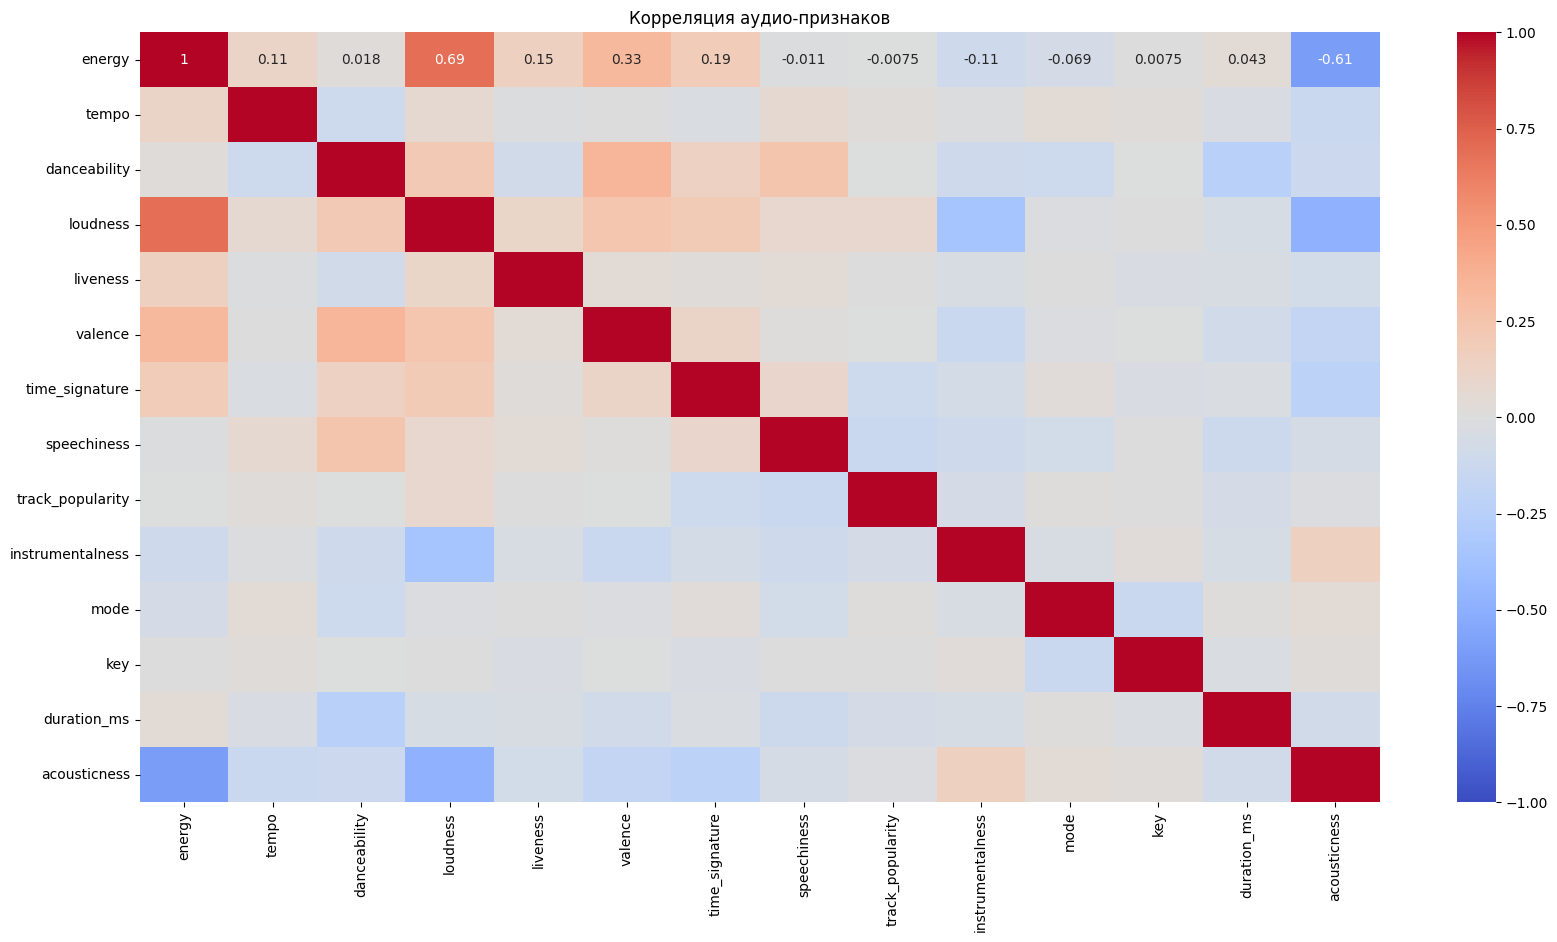

In [127]:
# С помощью функции corr определяю корреляцию между признаками, результат записываю в переменную corr
corr = df_cluster[audio_features].corr()
# Отображаю матрицу корреляции
plt.figure(figsize=(20, 10))
# Добавляю "Тепловую карту" на матрицу
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция аудио-признаков')
plt.show()

**Исходя из результатов матрицы корреляции оптимальными признаками для кластеризации музыкальных треков являются:**
1) energy (энергичность)
2) danceability (танцевальность)
3) valence (позитивность)
4) acousticness (акустичность)

**Обоснование  выбора признаков**
Признак energy и acousticness имеют сильную отрицательную корреляцию -61, они показывают два противоположных аспекта музыки. Energy — характеризует интенсивность и активность трека, высокие значения указывают на энергичные, громкие треки, низкие — на спокойные и расслабляющие, а acousticness указывет на разделение музыки на инструментальный состав, например как на электронную музыку (искусственно созданную) и акустическую.
Признак energy и loudness  сильно коррелируются между собой (0,69), можно считать, что два этих признака могут дублировать друг друга, поэтому для кластеризации не будем использовать loudness (громкость). Признак energy может кластеризовать по энергичным и спокойным трекам. 
Признак danceability имеет умеренную корреляцию с признаком valence (0,35), что говорит о том, что танцевальные треки в основном позитивные, однако у danceability слабая корреляция с energy - это говорит о важной независимости треков для кластеризации. Признак danceability позволит определить подходит ли трек для активных и веселых танцев. 
Признак valence также слабо коррелируется с energy  и имеет отрицательную связь с acousticness. Признак  valence позволит отделить грустные треки от веселых. 
Признак acousticness является ключевым параметром для определения акустической музыки в треке. 

In [128]:
# Создаю список названия стобцов, которые представляют характеристики музыкальных треков (признаки) - ds_columns
ds_columns = ['track_id', 'track_artist', 'track_name', 'energy', 'danceability', 'valence', 'acousticness']
# Вывожу первые 20 строк нового датафрейма ds_cluster (после отбора столбцов и удаления пропущенных значений)
ds_cluster[ds_columns].head(20)

,track_id,track_artist,track_name,energy,danceability,valence,acousticness
0,2plbrEY59IikOBgBGLjaoe,"Lady Gaga, Bruno Mars",Die With A Smile,-0.372443,-0.831938,0.033027,0.316766
1,6dOtVTDdiauQNBQEDOtlAB,Billie Eilish,BIRDS OF A FEATHER,-0.820215,0.606730,-0.375244,-0.107494
2,7ne4VBA60CxGM75vw0EYad,Gracie Abrams,That’s So True,0.765426,-0.621867,-0.653036,-0.052498
3,1d7Ptw3qYcfpdLNL5REhtJ,Sabrina Carpenter,Taste,1.302753,0.116564,1.089479,-0.524290
4,5vNRhkKd0yEAg8suGBpjeY,"ROSÉ, Bruno Mars",APT.,0.633728,0.797704,1.733452,-0.781989
5,0WbMK4wrZ1wFSty9F7FCgu,Chappell Roan,"Good Luck, Babe!",-0.425122,0.307538,1.085270,-0.695958
6,6MzofobZt2dm0Kf1hTThFz,Addison Rae,Diet Pepsi,-0.535748,0.110199,1.320973,1.051364
7,3QaPy1KgI7nu9FJEQUgn6h,Billie Eilish,WILDFLOWER,-2.189872,-1.175691,-1.688444,1.510979
8,0UYnhUfnUj5adChuAXvLUB,Gigi Perez,Sailor Song,-1.299595,-1.016546,-0.968709,1.801675
9,1Es7AUAhQvapIcoh3qMKDL,"The Weeknd, Playboi Carti",Timeless (with Playboi Carti),0.312386,0.746778,0.180341,-0.663746


### **Матрицы «объект-признак», «объект-объект»**

Стандартизация данных для выбранных признаков:

Так как были выбраны признаки, которых существенно меньше всех количественных признаков, то распределение стало другим и необходимо выполнить повторную стандартизацию для выбранных признаков

In [129]:
# создаю объект StandardScaler для стандартизации данных
scaler = StandardScaler()
# создаю список, который содержит имена столбцов которые нужно стандартизировать
feat = ['energy', 'danceability', 'valence', 'acousticness']
# выполняю стандартизацию: ds_cluster[feat] - выбор столбцов из ds_cluster по списку feat, с помощью функции fit_transform вычисляю среднее и стандартное отклонение для каждого признака, а зачем применяю стандартизацию, результат записываю обратно в ds_cluster[feat]
ds_cluster[feat] = scaler.fit_transform(ds_cluster[feat])

C:\Users\marga\AppData\Local\Temp\ipykernel_23900\1222745361.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster[feat] = scaler.fit_transform(ds_cluster[feat])


Создание матрицы объект-признак:

In [130]:
# Создаю список selected_columns, содержащий названия столбцов, которые отображают признаки датафрейма ds_cluster и добавляю track_id для идертификации строки 
selected_columns = ['track_id','energy', 'danceability', 'valence', 'speechiness', 'acousticness']
# Из датафрейма ds_cluster выбираю только столбцы, перечисленные в переменной selected_columns для построения матрицы объект-признак и вывожу первые 20 строк
print("Матрица объект-признак:")
ds_cluster[selected_columns].head(20)

Матрица объект-признак:


,track_id,energy,danceability,valence,speechiness,acousticness
0,2plbrEY59IikOBgBGLjaoe,-0.372443,-0.831938,0.033027,-0.695951,0.316766
1,6dOtVTDdiauQNBQEDOtlAB,-0.820215,0.606730,-0.375244,-0.641855,-0.107494
2,7ne4VBA60CxGM75vw0EYad,0.765426,-0.621867,-0.653036,-0.631837,-0.052498
3,1d7Ptw3qYcfpdLNL5REhtJ,1.302753,0.116564,1.089479,-0.365366,-0.524290
4,5vNRhkKd0yEAg8suGBpjeY,0.633728,0.797704,1.733452,1.604116,-0.781989
5,0WbMK4wrZ1wFSty9F7FCgu,-0.425122,0.307538,1.085270,-0.643859,-0.695958
6,6MzofobZt2dm0Kf1hTThFz,-0.535748,0.110199,1.320973,-0.588761,1.051364
7,3QaPy1KgI7nu9FJEQUgn6h,-2.189872,-1.175691,-1.688444,-0.568726,1.510979
8,0UYnhUfnUj5adChuAXvLUB,-1.299595,-1.016546,-0.968709,-0.746039,1.801675
9,1Es7AUAhQvapIcoh3qMKDL,0.312386,0.746778,0.180341,-0.492591,-0.663746


Создание матрицы объект-объект:

In [131]:
# Из датафрейма ds_cluster удаляю столбцы track_id, track_artist и track_name с помощью метода drop, так как они не являются числовыми и не нужны для вычисления расстояний
data = ds_cluster.drop(columns=['track_id', 'track_artist', 'track_name']).values

# Матрица "объект-объект" с евклидовым расстоянием
# С помощью функции pairwise_distances вычисляю попарные расстояния (евклидово расстояние) между объектами в массиве data
distance_matrix_euclidean = pairwise_distances(data)
# Преобразую матрицу расстояний в датафрейм с помощью функции pd.DataFrame
distance_df_euclidean = pd.DataFrame(distance_matrix_euclidean, index=ds_cluster.index, columns=ds_cluster.index)
# Вывожу таблицу объект-объект c матрицей попарных растояний
print("Матрица объект-объект:")
pd.set_option('display.max_columns', None)
distance_df_euclidean

Матрица объект-объект:


0         1         2         3         4         5         6     \
0     0.000000  4.783820  5.083991  6.186941  5.661814  4.385514  5.008201   
1     4.783820  0.000000  2.901679  5.101837  5.090285  3.898164  4.059609   
2     5.083991  2.901679  0.000000  3.789180  4.781486  4.361266  4.172832   
3     6.186941  5.101837  3.789180  0.000000  4.066615  4.712844  4.946941   
4     5.661814  5.090285  4.781486  4.066615  0.000000  4.838088  5.458433   
...        ...       ...       ...       ...       ...       ...       ...   
1680  7.465516  5.233213  4.951810  4.701414  7.305680  6.240199  5.250226   
1681  8.007917  6.243383  6.233617  5.711889  7.283882  5.139469  4.581866   
1682  6.371813  4.953405  4.578781  3.310536  5.990537  4.869354  4.547728   
1683  7.125243  6.039305  5.280963  3.544521  6.596767  5.033972  5.042306   
1685  7.465367  6.248042  5.078844  4.009089  6.586066  6.185277  5.180781   

          7         8         9         10        11        12        13    \
0     4.573441  7.331304  4.485072  5.831012  5.016520  6.270517  5.869708   
1     4.369429  5.969568  3.989650  3.771909  2.991931  4.316832  3.638801   
2     5.314095  5.949214  4.219853  3.825442  3.014712  2.756628  3.270938   
3     6.644009  6.301112  4.565941  4.353479  4.386167  2.573196  4.212354   
4     6.800651  8.495204  4.950140  5.252341  5.403571  5.321237  5.799865   
...        ...       ...       ...       ...       ...       ...       ...   
1680  6.277582  3.990023  5.816143  4.311736  4.410506  3.379553  4.442854   
1681  5.631985  4.574475  5.296903  5.413202  4.663577  5.487110  5.245214   
1682  5.567129  4.284651  4.573494  3.863748  3.927338  3.238498  4.063785   
1683  6.794384  4.709188  4.634709  4.386782  4.297411  3.341379  3.952488   
1685  6.908991  4.361541  5.597217  4.745553  4.610797  3.162951  4.687246   

          14        15        16        17        18        19        20    \
0     5.492824  6.139220  5.825824  4.838250  4.128457  5.386165  7.515351   
1     4.148157  5.889025  4.739210  4.158421  4.855845  4.310606  6.176010   
2     3.701420  4.824428  3.796887  3.323528  4.989223  4.351622  5.389666   
3     3.352346  4.042941  1.757255  2.312656  6.585554  3.645776  5.414403   
4     3.911448  5.222079  3.996931  4.170866  7.284571  4.881127  5.084008   
...        ...       ...       ...       ...       ...       ...       ...   
1680  5.335858  6.295447  4.475598  4.910895  6.038211  5.060563  6.964952   
1681  5.759654  6.097364  5.000685  5.043730  7.246826  5.216180  7.633924   
1682  4.773074  5.142094  3.042682  3.413312  5.745618  3.481384  6.188668   
1683  4.921206  4.953671  3.141241  3.509726  6.475120  4.199756  6.600446   
1685  4.458819  4.323431  3.616544  4.502165  6.383112  4.879352  5.544611   

          21        22        23        24        25        26        27    \
0     5.411169  5.559035  5.867661  4.913791  5.581373  6.422241  5.670991   
1     2.750776  4.569569  4.334286  3.485883  4.213526  5.091514  3.232797   
2     1.874474  4.588979  4.260022  3.407481  3.119494  5.122129  4.425707   
3     2.986947  4.035330  4.027306  3.239371  3.050979  4.743949  5.523513   
4     4.196124  4.719819  5.202913  4.514666  4.770716  6.420265  6.720153   
...        ...       ...       ...       ...       ...       ...       ...   
1680  4.595015  5.681842  3.915135  3.900766  4.460185  4.521802  4.041578   
1681  6.027037  5.321175  4.686285  4.857836  5.356927  4.838128  4.626093   
1682  4.146128  4.409836  2.601224  2.832880  4.070116  4.150636  3.861756   
1683  4.763555  4.307685  3.546514  3.640284  3.994877  3.526003  4.891515   
1685  4.844158  5.763607  4.516465  4.156027  3.515589  4.447417  5.153990   

          28        29        30        31        32        33        34    \
0     3.309908  4.608828  8.237050  5.564352  4.573906  5.900739  5.506902   
1     3.870033  3.184631  6.949008  3.367979  5.044404  5.828255  5.440784   
2     4.103676  2.685138  6.

### **Описание параметров выбранного метода кластеризации с обоснованием выбора**

Представлено в отдельном файле

### **Описание алгоритма кластеризации**

Для кластеризации музыкальных треков по их аудио-характеристикам я выбрала метод "Сгущение в сферах и их стабилизация"

Краткий алгоритм решения: 
1) метод предполагает заранее заданное количество кластеров (поиск заранее заданного количества кластеров с помощью метода "локтя" через Kmins)
2) метод имеет параметр R (радиус), необходимо выбрать радиусы для каждой сферы (класстера) на основании растояний до к - близжайшего соседа 

    $Ri = 1/N * сумм(d(x,kNN(x)))$, где kNN(x) — ближайший сосед точки x

3) центр первого кластера выбирается методом случайности
4) для каждого класстера находятся все точки, которые попадают в радиус сферы 

Точка x попадает в кластер C, если d(x,μi) <= Ri, х принадлежит только одному кластеру, если точка не попала в заданные кластеры, то помечается как -1 (шум)

5) Для каждого кластера вычисляется новый центроид (стабилизируется)
6) если новый центр приблизительно равен старому центру, то точка назначается центром, если нет то осуществляется пересчет 

**Определение количества кластеров:**

Для определения количества кластеров воспользуюсь методом "локтя"

c:\Users\marga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\marga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\marga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\marga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

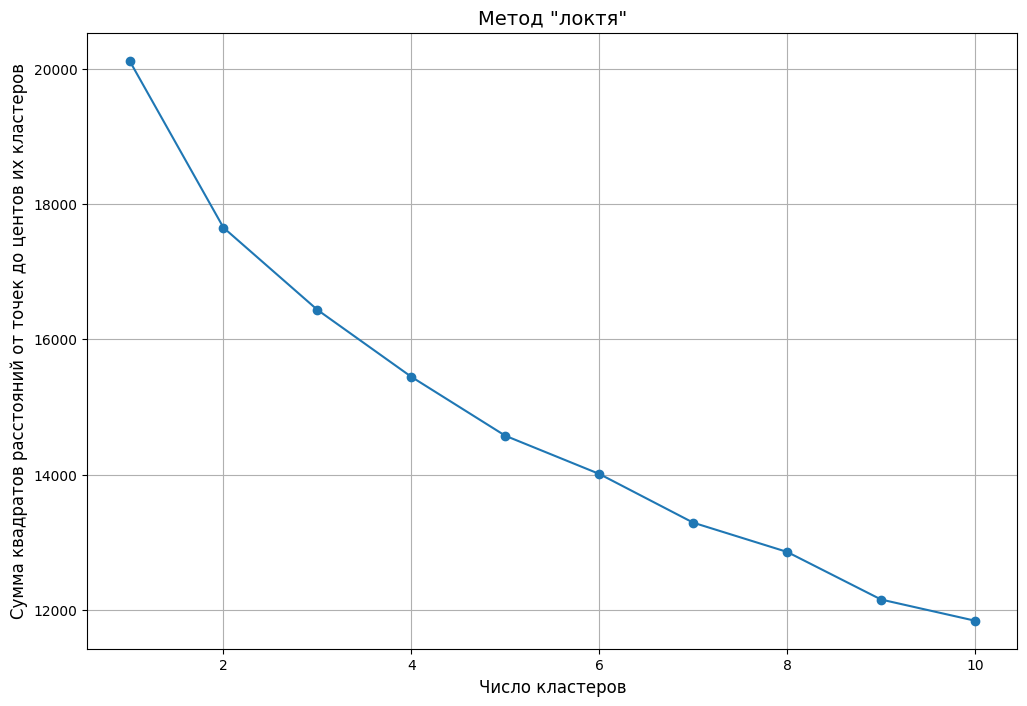

In [132]:
# создаю пустой список, в который буду сохранять сумму значений квадратов расстояний от точек до центов их кластеров (центры находятся случайным образом по методу KMeans)
wcss = []
# обозначаю максимальное число кластеров, которое будет отображено на графике
max_clusters = 10 
# подбираю оптимальное число классетров 
# запускаю цикл, который будет перебирать число кластеров от 1 до 10
for k in range(1, max_clusters + 1):
    # создаю модель KMeans с текущим числом кластеров и фиксирую случайность random_state=30 для воспроизведения результатов
    kmeans = KMeans(n_clusters=k, random_state=30)
    # модель обучается на данных
    kmeans.fit(data)
    # добавляю в список wcss сумму значений квадратов расстояний от точек до центов их кластеров для кажой идерации текущего кластера 
    wcss.append(kmeans.inertia_) 

# Вывожу график метода "локтя"
plt.figure(figsize=(12, 8))
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.xlabel('Число кластеров', fontsize=12)
plt.ylabel('Сумма квадратов расстояний от точек до центов их кластеров', fontsize=12)
plt.title('Метод "локтя"', fontsize=14)
plt.grid(True)
plt.show()

На графике сумма квадратов расстояний от точек до центов их кластеров отсутствует явный излом (локоть). 
Значения суммы квадратов расстояний от точки до центра их кластеров: 
k=1 приблизительно 20100;
k=2 приблизительно 17800;
k=3 приблизительно 16300;
k=4 приблизительно 15300;
k=5 приблизительно 14800;
k=6 приблизительно 14000;
k=7 приблизительно 13100;
k=8 приблизительно 12900;
k=9 приблизительно 12100;
k=10 приблизительно 11900

Наиболее заметное изменение значений суммы квадратов расстояний от точек до центов их кластеров наблюдается после 4 кластеров 

Воспользуюсь классом KneeLocator из библиотеки kneed для автоматического поиска локтя:

In [133]:
# Создаю обьект KneeLocator для анализа
kl = KneeLocator(
    # Задаю диапазон чисел кластеров от 1 до 7
    x=range(1, 11), 
    # Список значений суммы квадратов расстояний от точки до центра
    y=[20100, 17800, 16300, 15300, 14800, 14000, 13100, 12900, 12100, 11900],
    curve='convex', 
    # Задаю направление уменьшения значений суммы квадратов расстояний от точки до центра
    direction='decreasing'
)
# Вывожу оптимальное число кластеров
print('Оптимальное число кластеров:', kl.elbow)

Оптимальное число кластеров: 4


Таким образом, кластеризовавать буду на 4 кластера

Определение радиусов кластеров:

 Радиус первого радиуса = 0.7355240257446488
 Все радиусы = [0.7355240257446488, 1.4710480514892976, 2.2065720772339463, 2.9420961029785953]


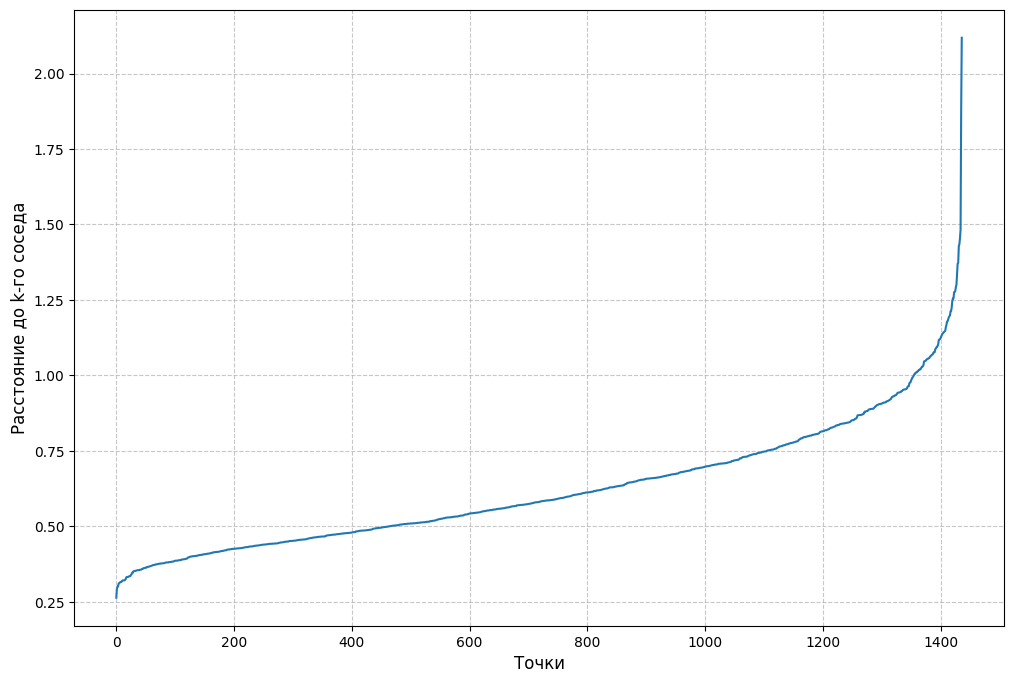

In [ ]:
# Устанавливаю количество соседей k = 10, которое будет использоваться для определения количества ближайших точек при расчёте радиусов
k = 10  
# Создаю экземпляр класса с помощью NearestNeighbors и указываю количество соседей, модель обучается на данных
neighbors = NearestNeighbors(n_neighbors=k).fit(ds_cluster[feat])
# С помощью метода kneighbors вычисляю расстояние от каждой точки до ее к-ближайших соседей, сохраняю все в переменную distances
distances, _ = neighbors.kneighbors(ds_cluster[feat])
# Для каждой точки извлекаю расстояние до её соседа и сохраняю все в k_distances
k_distances = distances[:, -1] 
# Рассчитываю радиус с помощью функции np.quantile. Радиус вычисляется с помощью 75-й перцентиль вместо медианы, так как медиана не захватывает многие точки
R = np.quantile(k_distances, 0.75) 
# Вывожу значение первого радиуса 
print(f" Радиус первого радиуса = {R}")
# Создаю список радиусов для других классеров
radii = [R, R*2, R*3, R*4] 
print(f" Все радиусы = {radii}")
plt.figure(figsize=(12, 8)) 
plt.plot(np.sort(k_distances))
plt.xlabel("Точки", fontsize=12)
plt.ylabel("Расстояние до k-го соседа", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7) 
plt.show()

Исходный радиус R = 0.7355240257446488 отражает "типичную" плотность данных, я умножаю радиус для исследования на разных масштабах. Таким образом, R - выделяет самые плотные сферы, Rх2 - захватывает ближайшие граничные точки от плотного ядра, Rх3 - захватывает точки, которые находятся чуть дальше от ядра, Rx4 - крайние элементы кластеров

**С помощью гистограммы распределения расстояний до k-го соседа можно просмотреть распределение плотности точек и выбранные радиусы**

На гистограмме отмечены 4 линии, соответствующие радиусам:

1) Зеленая (R): Базовый радиус (75-й процентиль расстояний)
2) Жёлтая (R×2): Удвоеный радиус
3) Синяя (R×3): Умеренно увеличенный радиус
3) Красная (R×4): Максимальный радиус

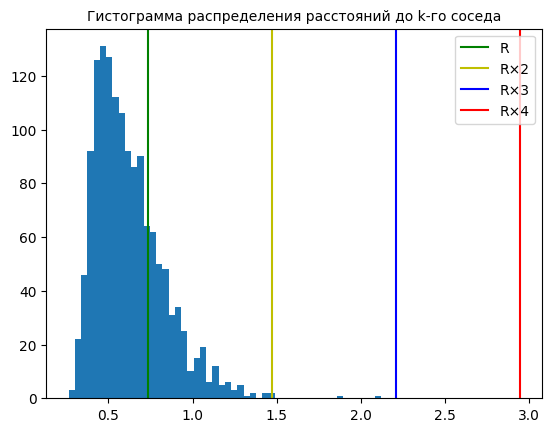

In [140]:
plt.hist(k_distances, bins=50)
plt.axvline(R, color='g', label='R')
plt.axvline(R*2, color='y', label='R×2')
plt.axvline(R*3, color='b', label='R×3')
plt.axvline(R*4, color='r', label='R×4')
plt.title('Гистограмма распределения расстояний до k-го соседа', fontsize=10)
plt.legend()
plt.show()

Исходя из графика распределения расстояний до k-ого соседа: Гистограмма показывает резкий спад после значения 1, так как большинство точек находится близко друг к другу. Справа имеются "остатки" точек, которые значительно удалены от основного скопления

**Анализ выбранных радиусов:**
1) R - находится примерно в центре основной плотности, примерно 80% точек имеют расстояние до k-го соседа меньше R, а 20% больше, это говорит о том, что положение хорошо подходит для разделения плотных участков
2) R×2 - находится в хвосте основной плотности, захватывает зону переходной плотности и объединяет близкие точки 
3) R×3 - находится в начале "остатков" точек и может объединять редкие треки в один кластр 
4) R×4 - находится в конце "остатков" точек и может объединять редкие треки в один кластр 

Исходя из гистограммы видно, что выбранные радиусы поделили распределение точек на приблизительно 4 равные части

**Кластеризация методом "Сгущение в сферах и их стабилизация":**

In [ ]:
# Создаю функцию sphere_clustering  для кластеризации на основе сфер 
def sphere_clustering(data, radii):
# Определяю количество объектов в данных и записываю количество данных в переменную n_samples
    n_samples = data.shape[0]
# Создаю пустой список clusters для хранения центов классеров
    clusters = []
# Создаю массив меток классеров, где объекты изнакольно имеют метку "-1", как не распределены в класстер
    labels = -1 * np.ones(n_samples, dtype=int)
# Создаю счетчик кластеров, при создании первого кластера он будет иметь идентификатор 0 
    cluster_id = 0

# Основной цикл класстеризации 
# Создаю цикл, который выполняется до тех пор пока есть объекты без меток и не превышено количество кластеров
    while np.any(labels == -1) and cluster_id < len(radii):
    # Случайным образом выбираю точку, которая будет центом сферы
        center_idx = np.random.choice(np.where(labels == -1)[0])
    # Индекс выбранного объекта сохраняю в переменной center
        center = data[center_idx]
    # Вывожу центр первой сферы
        print('Центр в итерациях = ', center_idx, center)
# Цикл стабилизации сфер
    # Создаю цикл для стабилизации центра сферы
        while True:
        # Вычисляю расстояние от выбранного центра до всех обьектов
            distances = pairwise_distances(data, [center]).flatten()
        # Определяю объекты, которые находятся внутри сферы и еще не имеют класстер
            in_sphere = (distances <= radii[cluster_id]) & (labels == -1)
        # Если внутри сферы нет новых объектов, то завершаю стабилизацию
            if not np.any(in_sphere):
                break
        # Пересчитываю центр сферы как среднее значение координат точек внутри сферы 
            new_center = data[in_sphere].mean(axis=0)
        # Если новый центр сферы находится на близком расстоянии к старому центру сферы, то завершаю стабилизацию
            if np.allclose(new_center, center):
                break
        # Перезаписываю новый центр сферы
            center = new_center
# Призвоение точке класстер
    # Присваиваю точке, находящейся внутри сферы, кластер 
        labels[in_sphere] = cluster_id
    # Центр класстера добавляю в список clusters
        clusters.append(center)
    # Счетчик кластера увеличиваю на 1 
        cluster_id += 1
# Функция возвращает переменные labels, clusters
    return labels, clusters

# Данные преобразую в массив с помощью values
data = ds_cluster[feat].values

# Создаю оъект neighbors для поиска близжайших соседей. Параметр n_neighbors=2 указывает на то, что нужно найти двух ближайших соседей, включая сам объект
neighbors = NearestNeighbors(n_neighbors=2)
# Модель обучается на данных data
neighbors_fit = neighbors.fit(data)
# С помощью метода neighbors_fit вичисляю расстояние до близжайших соседей для каждого объекта, в переменную distances записываю расстояние до близжайших соседей
distances, _ = neighbors_fit.kneighbors(data)

# Задаю радиусы для каждой сферы
radii =  [0.7355240257446487, 1.4710480514892974, 2.206572077233946, 2.942096102978595]

# Произвожу запуск медода кластеризации
labels, clusters = sphere_clustering(data, radii)

# В датафрейм ds_cluster добавляю новый столбец с метками кластеров 
ds_cluster['cluster'] = labels

# Вывод результатов
# Подсчет количества точек в каждом кластере
# Считаю количество точек в каждом кластере и записываю в переменную cluster_counts
cluster_counts = ds_cluster['cluster'].value_counts().sort_index()

# Вывожу результаты
print("\n Количество точек в каждом кластере:")
print(cluster_counts)

Центр в итерациях =  270 [ 0.24390281  0.58763285  0.77801506 -0.69635127]
Центр в итерациях =  1240 [-1.27325552  1.27513817 -0.29527349  0.78816546]
Центр в итерациях =  1291 [-2.81148549 -1.07383834 -1.36435306  2.82696987]
Центр в итерациях =  61 [ 1.47659395 -1.33483573  1.06843431 -0.8816507 ]

 Количество точек в каждом кластере:
cluster
-1     69
 0    101
 1    401
 2    514
 3    352
Name: count, dtype: int64


C:\Users\marga\AppData\Local\Temp\ipykernel_23900\535301143.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster['cluster'] = labels


Зафиксирую результат в полученных центрах для повтора воспроизведения. В случае если повторно выполнять запуск функции сверху, то результаты будут немного отличаться от полученных 

In [ ]:
# Создаю функцию sphere_clustering  для кластеризации на основе сфер 
def sphere_clustering_fixed(data, radii, fixed_centers_indices):
    # Определяю количество объектов в данных и записываю количество данных в переменную n_samples
    n_samples = data.shape[0]
    # Создаю пустой список clusters для хранения центов классеров
    clusters = []
    # Создаю массив меток классеров, где объекты изнакольно имеют метку "-1", как не распределены в класстер
    labels = -1 * np.ones(n_samples, dtype=int)
    # Создаю счетчик кластеров, при создании первого кластера он будет иметь идентификатор 0 
    cluster_id = 0

    # Проверка, что количество фиксированных центров соответствует количеству радиусов
    assert len(fixed_centers_indices) == len(radii), "Количество фиксированных центров должно совпадать с количеством радиусов"
# Основной цикл класстеризации 
# Создаю цикл, который выполняется до тех пор пока есть объекты без меток и не превышено количество кластеров
    while cluster_id < len(radii):
        # Беру фиксированный центр вместо случайного выбора
        center_idx = fixed_centers_indices[cluster_id]
        # Индекс выбранного объекта сохраняю в переменной center
        center = data[center_idx]
        # Вывожу центр первой сферы
        print('Центр в итерациях = ', center_idx, center)

        # Цикл стабилизации сферы
        # Создаю цикл для стабилизации центра сферы
        while True:
            # Вычисляю расстояние от выбранного центра до всех обьектов
            distances = pairwise_distances(data, [center]).flatten()
            # Определяю объекты, которые находятся внутри сферы и еще не имеют класстер
            in_sphere = (distances <= radii[cluster_id]) & (labels == -1)
            # Если внутри сферы нет новых объектов, то завершаю стабилизацию
            if not np.any(in_sphere):
                break
            # Если новый центр сферы находится на близком расстоянии к старому центру сферы, то завершаю стабилизацию     
            new_center = data[in_sphere].mean(axis=0)
            if np.allclose(new_center, center):
                break
            # Перезаписываю новый центр сферы   
            center = new_center
# Призвоение точке класстер
    # Присваиваю точке, находящейся внутри сферы, кластер 
        labels[in_sphere] = cluster_id
        # Центр класстера добавляю в список clusters
        clusters.append(center)
        # Счетчик кластера увеличиваю на 1 
        cluster_id += 1
# Функция возвращает переменные labels, clusters
    return labels, clusters

# Данные преобразую в массив с помощью values
data = ds_cluster[feat].values
# Фиксированные индексы центров, которые дали нужный результат
fixed_centers_indices = [270, 1240, 1291, 61]
# Задаю радиусы для каждой сферы
radii = [0.7355240257446487, 1.4710480514892974, 2.206572077233946, 2.942096102978595]
# Произвожу запуск медода кластеризации с фиксированными центрами
labels, clusters = sphere_clustering_fixed(data, radii, fixed_centers_indices)

# В датафрейм ds_cluster добавляю новый столбец с метками кластеров 
ds_cluster['cluster'] = labels

# Вывод результатов
cluster_counts = ds_cluster['cluster'].value_counts().sort_index()
print("\nКоличество точек в каждом кластере:")
print(cluster_counts)

Центр в итерациях =  270 [ 0.24390281  0.58763285  0.77801506 -0.69635127]
Центр в итерациях =  1240 [-1.27325552  1.27513817 -0.29527349  0.78816546]
Центр в итерациях =  1291 [-2.81148549 -1.07383834 -1.36435306  2.82696987]
Центр в итерациях =  61 [ 1.47659395 -1.33483573  1.06843431 -0.8816507 ]

Количество точек в каждом кластере:
cluster
-1     69
 0    101
 1    401
 2    514
 3    352
Name: count, dtype: int64


C:\Users\marga\AppData\Local\Temp\ipykernel_23900\404438807.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster['cluster'] = labels


**Исходя из результатов кластеризации:**
1) Класстер 0 (101 точек) - Энергичные бодрящие треки 
2) Класстер 1 (401 точек) - Атмосферные треки 
3) Класстер 2 (514 точек) - Основной кластер, возможно это поппулярные треки для вечеринок
4) Класстер 3 (352 точек) - Грустные треки
Некласстеризованные треки
1) Класстер -1 (69 точек) - Шум

C:\Users\marga\AppData\Local\Temp\ipykernel_23900\198657201.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster['tsne_x'] = data_2d[:, 0]
C:\Users\marga\AppData\Local\Temp\ipykernel_23900\198657201.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster['tsne_y'] = data_2d[:, 1]


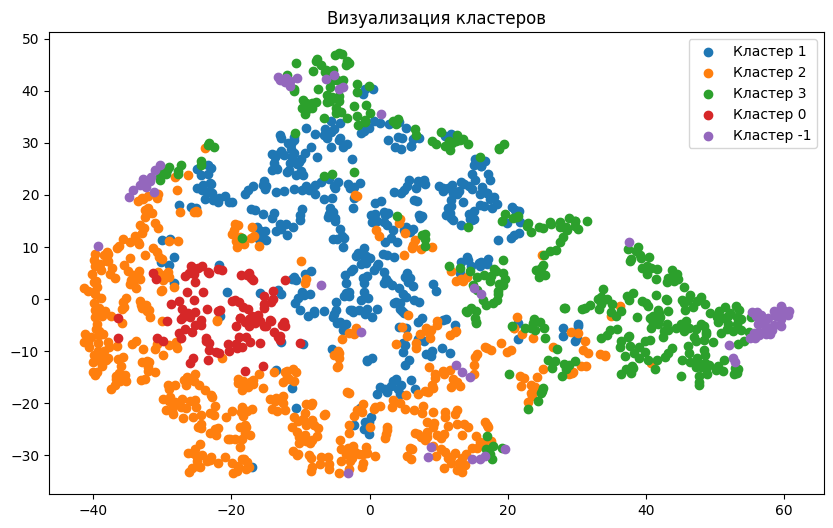

In [168]:
# Применяю функцию TSNE для снижения размерности до 2D
# Создаю объект tsne с параметрами n_components=2 для уменьшения данных до 2d и random_state=30 для фиксации случайного состояния при воспроизводимости результатов
tsne = TSNE(n_components=2, random_state=30)
# Применяю метод fit_transform к данным, чтобы преобразовать их в двумерное пространство. И записываю новые данные в переменную data_2d
data_2d = tsne.fit_transform(data)

# Добавляю координаты t-TSNE в датафрейм
# Добавляею столбец tsne_x, содержащий ось X и ось Y
ds_cluster['tsne_x'] = data_2d[:, 0]
ds_cluster['tsne_y'] = data_2d[:, 1]

# Визуализация кластеров
# Создаю фигуру для графиков
plt.figure(figsize=(10, 6))
# Для каждого класстера выбираю точки относящиеся к этому кластеру
for cluster in ds_cluster['cluster'].unique():
# Строю точечный график с использованием координат tsne_x и tsne_y
    cluster_data = ds_cluster[ds_cluster['cluster'] == cluster]
    plt.scatter(cluster_data['tsne_x'], cluster_data['tsne_y'], label=f'Кластер {cluster}')

# Добавляю заголовок 
plt.title('Визуализация кластеров')
# Добавляю легенду для подписей кластеров
plt.legend()
# Вывожу график
plt.show()

Кластер 0, 1, 2, 3, — это основные группы, на которые разбились музыкальные треки по их аудио-характеристикам, кластер -1 — это "шум" или "не распределённые треки", которые не попали ни в один из кластеров. Кластер -1 содержит менее 20% данных - условие полноты покрытия выполнено, отсутсвует пересечение кластеров

### **Результаты кластеризации**

In [169]:
# Создаю список с наименованием столбцов
selected_columns = ['track_id','track_artist','track_name','energy','tempo','danceability','valence','loudness','acousticness']

In [170]:
# Выбираю строки из датафрейма которые относятся к кластеру 0, результат сохраняю в переменную ds_cluster_0
ds_cluster_0 = ds_cluster[ds_cluster['cluster'] == 0]
# Вывожу количество объектов в кластере 
print('Количество объектов в кластере 0 =',ds_cluster_0['track_id'].count())
# Вывожу первые 20 строчек из кластера 0
ds_cluster_0[selected_columns].head(10) 

Количество объектов в кластере 0 = 101


,track_id,track_artist,track_name,energy,tempo,danceability,valence,loudness,acousticness
9,1Es7AUAhQvapIcoh3qMKDL,"The Weeknd, Playboi Carti",Timeless (with Playboi Carti),0.312386,-0.049437,0.746778,0.180341,0.374334,-0.663746
10,3WOhcATHxK2SLNeP5W3v1v,"Charli xcx, Billie Eilish",Guess featuring billie eilish,0.022651,0.317812,0.791338,0.382371,0.052333,-0.835807
13,2FQrifJ1N335Ljm3TjTVVf,Shaboozey,A Bar Song (Tipsy),0.243903,-1.473722,0.447585,0.323446,0.525847,-0.644497
16,5G345YEhvleYxQLfYUlEFv,LISA,Moonlit Floor (Kiss Me),0.654800,-0.416246,0.523975,0.609656,0.808767,-0.398191
19,1BJJbSX6muJVF2AK7uH1x4,"Adam Port, Stryv, Keinemusik, Orso, Malachiii",Move,0.628460,-0.048742,0.479414,0.538104,-0.487735,-0.671996
21,2qSkIjg1o9h3YT9RAgYN75,Sabrina Carpenter,Espresso,0.512566,-0.634490,0.313904,0.685418,0.376316,-0.472829
33,0qeIFEGRQqHoaJtLCl0U73,"Myke Towers, benny blanco",DEGENERE 👑 (feat. benny blanco),0.243903,2.658756,0.587633,0.778015,0.291356,-0.696351
63,1gzIbdFnGJ226LTl0Cn2SX,Billy Idol,White Wedding - Pt. 1,0.797033,0.945636,0.135662,0.845359,0.395291,-0.840521
79,2LawezPeJhN4AWuSB0GtAU,Creedence Clearwater Revival,Have You Ever Seen The Rain,0.180688,-0.190692,0.568535,1.038971,-0.062648,-0.632319
113,3EYOJ48Et32uATr9ZmLnAo,The Police,Roxanne,0.449351,0.467512,-0.214457,0.571775,-0.594219,-0.742313


Кластер 0 (101 треков) - Энергичные поп и электронные треки

Ключевые черты:
1) Средняя энергия (energy 0.4–0.6)
2) Высокая танцевальность (danceability 0.5-0.8)
3) Умереная позитивность (valence 0.3 до 0.7) - могут быть как позитивные треки, так и нейтральные
4) Низкая акустичность (acousticness -0.7) - в основном электронная музыка

Этот кластер объединяет поп-хиты, электронику и рок-треки с упором на ритм и энергичность. Подходит для динамичных плейлистов. В основном музыка состоит из электронного звучания. В рекомандациях может быть добавлено в категорию "Веселое". При составлении прейлиста может быть помечена названием "На любое время дня".

In [171]:
# Выбираю строки из датафрейма которые относятся к кластеру 1, результат сохраняю в переменную ds_cluster_1
ds_cluster_1 = ds_cluster[ds_cluster['cluster'] == 1]
# Вывожу количество объектов в кластере 
print('Количество объектов в кластере 1 =',ds_cluster_1['track_id'].count())
# Вывожу первые 20 строчек из кластера 1
ds_cluster_1[selected_columns].head(10)

Количество объектов в кластере 1 = 401


,track_id,track_artist,track_name,energy,tempo,danceability,valence,loudness,acousticness
0,2plbrEY59IikOBgBGLjaoe,"Lady Gaga, Bruno Mars",Die With A Smile,-0.372443,1.339571,-0.831938,0.033027,-0.274767,0.316766
1,6dOtVTDdiauQNBQEDOtlAB,Billie Eilish,BIRDS OF A FEATHER,-0.820215,-0.597604,0.606730,-0.375244,-0.952754,-0.107494
2,7ne4VBA60CxGM75vw0EYad,Gracie Abrams,That’s So True,0.765426,-0.467097,-0.621867,-0.653036,0.747029,-0.052498
11,5N3hjp1WNayUPZrA8kJmJP,Sabrina Carpenter,Please Please Please,-0.404050,-0.521091,0.110199,0.218221,0.207811,0.183202
12,1f18HzFpegqvH4ibGJyeMJ,Tate McRae,2 hands,0.754890,-0.632187,-0.278115,0.251893,0.952634,-0.417833
15,19KlZwqlT3fguP2BeHF1Q1,Lady Gaga,Disease,1.339628,-0.743502,-0.570941,-0.110079,1.143796,-0.691637
24,2c7z5oRcPBbqRaBY2mLWcf,Don Toliver,NEW DROP,-0.182798,-0.049181,0.670388,-0.867694,0.025995,-0.150706
25,7221xIgOnuakPdLqT0F3nP,"Post Malone, Morgan Wallen",I Had Some Help (Feat. Morgan Wallen),1.013018,0.243492,-0.087141,0.857986,0.551336,-0.863423
29,3Vr3zh0r7ALn8VLqCiRR10,Myles Smith,Stargazing,-0.325032,0.097558,-0.106238,-0.821395,0.191952,0.073209
31,46kspZSY3aKmwQe7O77fCC,Ariana Grande,we can't be friends (wait for your love),-0.087976,-0.200452,-0.042580,-0.977127,-0.432510,-0.651568


Кластер 1 (401 трек) - Мелодичные и меланхоличные треки

Ключевые черты:

1) Низкая энергия (energy 0.5–0.2)
2) Средняя танцевальность (danceability -0.2–0.6) - возможно медленные танцы
3) Низкая позитивность (valence -0.5–0.2) - грустные или нейтральные эмоции
4) Умереная акустичность (acousticness -0.5–0.3)

Треки с глубокими вокальными партиями, меланхоличными текстами и атмосферным звучанием. Подходят для вечернего прослушивания. В рекомандациях может быть добавлено в категорию "Спокойное". При составлении прейлиста может быть помечена названием "Атмосферное звучание".

In [174]:
# Выбираю строки из датафрейма которые относятся к кластеру 2, результат сохраняю в переменную ds_cluster_2
ds_cluster_2 = ds_cluster[ds_cluster['cluster'] == 2]
# Вывожу количество объектов в кластере
print('Количество объектов в кластере 2 =',ds_cluster_2['track_id'].count())
# Вывожу первые 20 строчек в кластере 2
ds_cluster_2[selected_columns].head(10)

Количество объектов в кластере 2 = 514


,track_id,track_artist,track_name,energy,tempo,danceability,valence,loudness,acousticness
3,1d7Ptw3qYcfpdLNL5REhtJ,Sabrina Carpenter,Taste,1.302753,-0.305589,0.116564,1.089479,0.775066,-0.524290
4,5vNRhkKd0yEAg8suGBpjeY,"ROSÉ, Bruno Mars",APT.,0.633728,1.012681,0.797704,1.733452,0.659802,-0.781989
5,0WbMK4wrZ1wFSty9F7FCgu,Chappell Roan,"Good Luck, Babe!",-0.425122,-0.168648,0.307538,1.085270,0.239813,-0.695958
6,6MzofobZt2dm0Kf1hTThFz,Addison Rae,Diet Pepsi,-0.535748,1.050773,0.110199,1.320973,0.076122,1.051364
14,4xdBrk0nFZaP54vvZj0yx7,Chappell Roan,HOT TO GO!,0.496763,0.682026,0.574901,1.809214,0.517068,-0.819701
17,7hR22TOX3RorxJPcsz5Wbo,Morgan Wallen,Love Somebody,0.949803,0.027003,-0.208091,0.921120,0.413133,-0.855920
20,3tFed7YsjGnIfxeLEQwx3R,"Tyler, The Creator, GloRilla, Sexyy Red, Lil W...","Sticky (feat. GloRilla, Sexyy Red & Lil Wayne)",0.786498,-1.507427,-0.933791,0.575984,0.798855,0.226414
22,2CspwnypzT7rcWI9RfsoSb,JENNIE,Mantra,0.328189,-0.158558,1.542501,1.308346,0.516219,-0.876112
26,4IadxL6BUymXlh8RCJJu7T,Hozier,Too Sweet,-0.224941,-0.156730,0.568535,1.712407,0.368670,-0.777275
28,1cOboCuWYI2osTOfolMRS6,"Oscar Maydon, Fuerza Regida",Tu Boda,-0.061636,-0.317214,0.269343,-0.236348,-0.045656,1.055292


Кластер 2 (514 треков) - Яркие поп, латинские и танцевальные хиты

Ключевые черты:

1) Высокие значения энергии, танцевальности и позитивности (energy 0.5–1.3, danceability 0.5–1.5, valence  0.7–1.8)
2) Низкая акустичность (acousticness -0.8–1.2) - смесь электроники и живых инструментов

Поп, латинские и танцевальны хиты с яркими мелодиями и высокой эмоциональной заряженностью. Идеальны для вечеринок. В рекомандациях может быть добавлено в категорию "Бодрое". При составлении прейлиста может быть помечена названием "Для вечеринок и танцев".

In [173]:
# Выбираю строки из датафрейма которые относятся к кластеру 3, результат сохраняю в переменную ds_cluster_3
ds_cluster_3 = ds_cluster[ds_cluster['cluster'] == 3]
# Вывожу количество объектов в кластере
print('Количество объектов в кластере 3 =',ds_cluster_3['track_id'].count())
# Вывожу первые 20 строчек в кластере 2
ds_cluster_3[selected_columns].head(20)

Количество объектов в кластере 3 = 352


,track_id,track_artist,track_name,energy,tempo,danceability,valence,loudness,acousticness
7,3QaPy1KgI7nu9FJEQUgn6h,Billie Eilish,WILDFLOWER,-2.189872,0.978830,-1.175691,-1.688444,-1.471298,1.510979
8,0UYnhUfnUj5adChuAXvLUB,Gigi Perez,Sailor Song,-1.299595,-0.965072,-1.016546,-0.968709,-1.028652,1.801675
18,51rfRCiUSvxXlCSCfIztBy,Gracie Abrams,"I Love You, I'm Sorry",-1.352274,-0.196870,-0.774646,-0.796141,-0.198302,1.683825
23,0l0vcZMU7AOeQmUIREoI2U,"Rauw Alejandro, Bad Bunny",Qué Pasaría...,-0.525212,-0.596507,1.154188,-0.775097,0.343748,1.180999
27,3siwsiaEoU4Kuuc9WKMUy5,The Marías,No One Noticed,-1.705224,-0.853099,0.339367,-0.295273,-1.077646,1.275279
32,6tNQ70jh4OwmPGpYy6R2o9,Benson Boone,Beautiful Things,-1.009860,-0.595740,-1.143862,-1.297009,0.315711,-0.299983
39,2OzhQlSqBEmt7hmkYxfT6m,"Taylor Swift, Post Malone",Fortnight (feat. Post Malone),-1.457632,2.583778,-0.940157,-1.036053,-1.180732,1.078862
41,6AI3ezQ4o3HUoP6Dhudph3,Kendrick Lamar,Not Like Us,-1.004592,-0.740797,1.567965,-1.318054,-0.055001,-0.851128
48,57bgtoPSgt236HzfBOd8kj,AC/DC,Thunderstruck,1.197395,0.445797,-0.952888,-1.128650,0.462127,-0.892583
49,3dPQuX8Gs42Y7b454ybpMR,The White Stripes,Seven Nation Army,-1.141558,0.083008,0.581267,-1.048680,-0.283263,-0.877840


Кластер 3 (352 трека) - Мрачные и деспессивные треки

Ключевые черты:

1) Очень низкая энергия (energy -2.0–0.0)
2) Низкая танцевальность (danceability -1.0–0.5)
3) Очень низкая позитивность (valence -1.8–0.0) - депрессивные или тревожные эмоции
4) Высокая акустичность (acousticness ≈ 0.8–1.8) - много живых инструментов

Глубокие, интроспективные и альтернативные треки с мрачной атмосферой. Подходят для вдумчивого прослушивания. В рекомандациях может быть добавлено в категорию "Грустное". При составлении прейлиста может быть помечена названием "Наедине с собой".

In [176]:
# Выбираю строки из датафрейма которые не относятся ни к одному из кластеров, результат сохраняю в переменную ds_cluster_2
ds_cluster_4 = ds_cluster[ds_cluster['cluster'] == -1]
# Вывожу количество объектов
print('Количество объектов не вошедших в кластеры =',ds_cluster_4['track_id'].count())
# Вывожу первые 20 строчек из объектов не вошедших в кластеры
ds_cluster_4[selected_columns].head(10)

Количество объектов не вошедших в кластеры = 69


,track_id,track_artist,track_name,energy,tempo,danceability,valence,loudness,acousticness
61,6L89mwZXSOwYl76YXfX13s,Green Day,Basket Case,1.476594,-1.325594,-1.334836,1.068434,1.020036,-0.881651
70,0dOg1ySSI7NkpAe89Zo0b9,Bruce Springsteen,Born in the U.S.A.,1.524005,0.028064,-1.614930,0.239266,0.216590,-0.891695
119,1L94M3KIu7QluZe63g64rv,Pearl Jam,Alive,1.118376,-1.693171,-2.340631,0.285565,0.208944,-0.863620
125,0Puj4YlTm6xNzDDADXHMI9,Beastie Boys,Sabotage,1.450254,1.711060,-2.085999,0.066698,-0.148741,-0.767454
126,0PdM2a6oIjqepoEfcJo0RO,Def Leppard,Pour Some Sugar On Me - Remastered 2017,1.529273,-1.328336,-2.448849,0.171923,0.540291,-0.884872
130,6qLEOZvf5gI7kWE63JE7p3,Stone Temple Pilots,Interstate Love Song - 2019 Remaster,1.392307,1.809142,-2.779870,-0.156377,-0.147325,-0.892088
137,6hTcuIQa0sxrrByu9wTD7s,Bruce Springsteen,Born to Run,1.481862,0.914709,-2.429752,0.331864,0.738533,-0.873480
138,648TTtYB0bH0P8Hfy0FmkL,Nat King Cole,Unforgettable,-2.532286,0.539894,-1.926854,-1.469577,-1.897518,2.720905
139,2xizRhme7pYeITbH1NLLGt,"Pyotr Ilyich Tchaikovsky, André Previn, London...","Tchaikovsky: Swan Lake, Op. 20, Act 2: No. 10,...",-2.627109,-2.303887,-3.282767,-1.919938,-3.384049,2.685550
140,3DNRdudZ2SstnDCVKFdXxG,"Ludwig van Beethoven, Paul Lewis","Sonata No. 14 ""Moonlight"" in C-Sharp Minor"", O...",-3.463284,1.801757,-2.977210,-1.583220,-8.625564,3.015530


Треки не вошедшие в кластер (69 треков) - шум
1) energy = -3.2 (очень низкая) и danceability = 2.3 (аномально высокая)
2) Треки могут иметь высокую energy и низкую valence
3) Экстремальная acousticness, есть треки полностью акустические (1) или полностью электронные (-1), в кластерах преобладают гибридные формы

### **Проверка результатов с описанием метода проверки**

Для проверки результатов кластеризации использую метод Calinski-Harabasz Score.
Метрика для оценки качества кластеризации, основанная на соотношении: дисперсии внутри кластеров (чем компактнее кластеры, тем лучше) к дисперсии между кластерами (чем дальше кластеры друг от друга, тем лучше)

In [177]:
# Загружаю функцию calinski_harabasz_score из библиотеки scikit-learn, которая вычисляет индекс Калински-Харабаша
from sklearn.metrics import calinski_harabasz_score
# Создаю функцию evaluate_clustering, которая принимает матрицу признаков и массив меток кластеров
def evaluate_clustering(data, labels):
    # Нахожу все уникальные значения в массиве labels, где -1 обозначает шум
    unique_labels = np.unique(labels)
    # Вычитаю 1 из общего числа уникальных меток (шум)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    # Выполняется проверка количества класстеров 
    if n_clusters < 2:
        raise ValueError("Отсутствуют класстеры")
    # Применяю функцию Calinski-Harabasz к данным и меткам
    ch_score = calinski_harabasz_score(data, labels)
    # Значение индекс
    print(f"Calinski-Harabasz Score: {ch_score:.1f}")
evaluate_clustering(data, labels)

Calinski-Harabasz Score: 170.9


Результат Calinski-Harabasz Score: 170.9 указывает на умеренное качество кластеризации. Кластеры различимы, но не идеальны — возможны перекрытия или неоптимальное число групп. 
Такой результат может быть связан с тем, что выбранный датасет имеет музыкальные треки, которые имеют смешаные жанры и плавные переходы energy, valence. В треках нет четко выреженых музыкальных сталей и некоторые треки могут одинаково хорошо относиться к разным кластерам 